In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, fftpack
from scipy import signal as sig
from random import choice

PATH = '/Users/carterdemars/Desktop/pv_data/pv_time_series.csv'

In [4]:
pv_df = pd.read_csv(PATH)

In [5]:
pv_df.head()

,system_id,timestamp,instantaneous_power_W,temperature_C,voltage
0,10441,2015-01-01 08:00:00,108.000000,2.933333,231.000000
1,10441,2015-01-01 08:15:00,573.333333,3.233333,229.333333
2,10441,2015-01-01 08:30:00,780.000000,6.000000,230.333333
3,10441,2015-01-01 08:45:00,1002.666667,3.666667,232.000000
4,10441,2015-01-01 09:00:00,1264.333333,8.133333,231.666667


# TODO: probably not ideal to pick a random site given that some sites have poor data

In [6]:
sample_site = pv_df[pv_df['system_id'] == choice(pv_df['system_id'].unique())]

In [7]:
sample_site.head()

,system_id,timestamp,instantaneous_power_W,temperature_C,voltage
30425887,8795,2015-01-01 08:15:00,63.500000,11.500000,225.000000
30425888,8795,2015-01-01 08:30:00,233.666667,14.000000,227.333333
30425889,8795,2015-01-01 08:45:00,454.333333,16.000000,228.000000
30425890,8795,2015-01-01 09:00:00,784.333333,18.666667,230.666667
30425891,8795,2015-01-01 09:15:00,1007.000000,21.000000,228.000000


In [8]:
from datetime import datetime
sample_site['timestamp'] = sample_site['timestamp'].apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())

/var/folders/7g/4cb0n6ln6dj_vbm8hpn1jcsm0000gn/T/ipykernel_8068/3408435467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_site['timestamp'] = sample_site['timestamp'].apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())


In [9]:
daily_max = sample_site.groupby('timestamp')['instantaneous_power_W'].max().rolling(30).mean()
daily_avg = sample_site.groupby('timestamp')['instantaneous_power_W'].mean().rolling(30).mean()

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

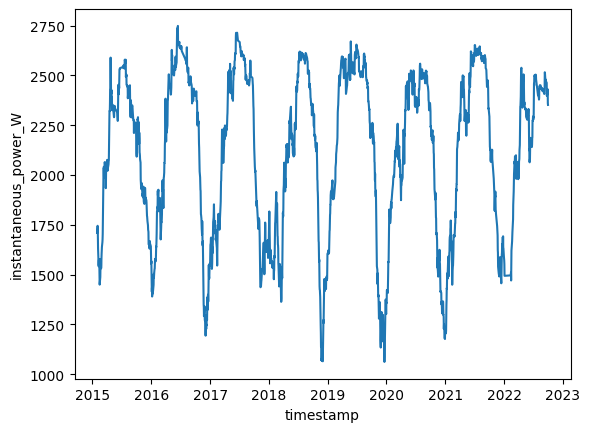

In [10]:
sns.lineplot(daily_max)

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

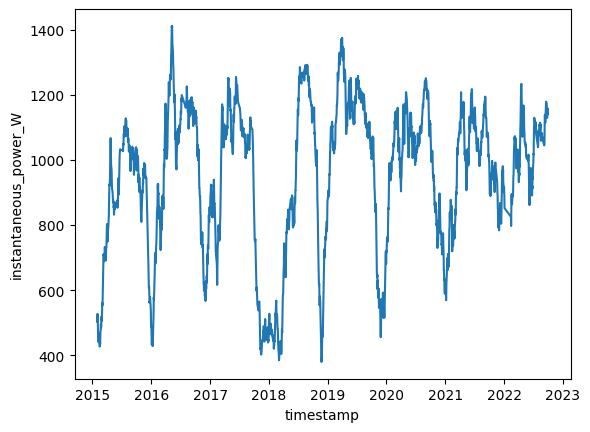

In [11]:
sns.lineplot(daily_avg)

In [12]:
all_site_agg = pv_df.groupby('timestamp')['instantaneous_power_W'].mean()

In [13]:
all_site_agg.rolling(100).mean().tail(100)

timestamp
2022-09-30 23:00:00     635.117672
2022-09-30 23:15:00     635.060635
2022-09-30 23:30:00     635.004524
2022-09-30 23:45:00     634.948043
2022-10-01 00:00:00     634.926228
                          ...     
2022-10-01 22:45:00    1213.616956
2022-10-01 23:00:00    1213.742286
2022-10-01 23:15:00    1213.904247
2022-10-01 23:30:00    1214.083256
2022-10-01 23:45:00    1214.262265
Name: instantaneous_power_W, Length: 100, dtype: float64

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

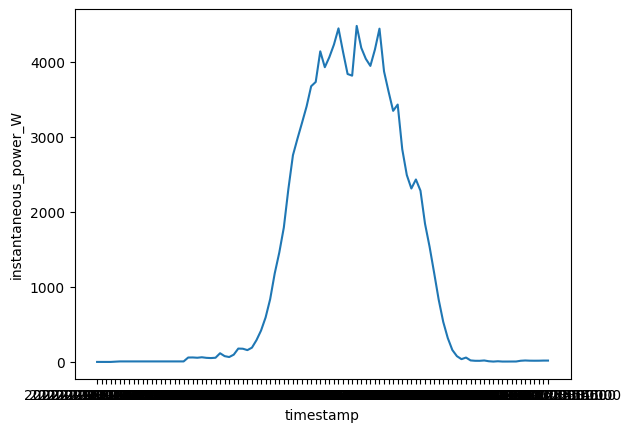

In [14]:
sns.lineplot(all_site_agg.tail(100))

# TODO: clean up this code

In [15]:

sample_site = pv_df.groupby('timestamp')['instantaneous_power_W'].mean()
# sample_site.index = sample_site['timestamp'].apply(lambda d: datetime.strptime(d,'%Y-%m-%d %H:%M:%S'))

In [16]:
#sample_site.index.name = 'time'
# sample_site['timestamp'] = sample_site.index.apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())
#sample_site.index = sample_site['time'].apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())
s = sample_site.to_frame()
s.index = pd.Series(s.index).apply(lambda d: datetime.strptime(d[:10], '%Y-%m-%d').date())
sample_site = s.groupby(s.index.name)['instantaneous_power_W'].max()

In [17]:
sample_site

timestamp
2015-01-01    4254.100000
2015-01-02    4933.530667
2015-01-03    5520.361111
2015-01-04    4297.120219
2015-01-05    5777.976667
                 ...     
2022-09-27    4833.480392
2022-09-28    3955.286738
2022-09-29    3855.142262
2022-09-30    2278.773333
2022-10-01    4475.158956
Name: instantaneous_power_W, Length: 2831, dtype: float64

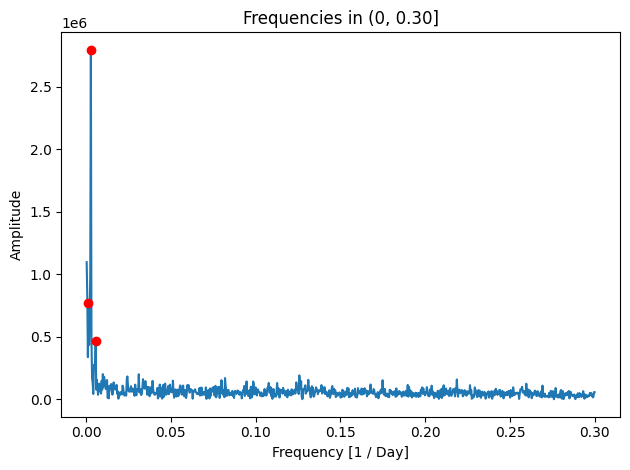

In [18]:
# Fourier Features
time_index =  pd.Series([i for i in range (len(sample_site.index))])
series = sample_site.values

fft_output = fftpack.fft(series)
power = np.abs(fft_output)
freq = fft.fftfreq(len(series))

mask = (freq > 0) & (freq <= 0.3)
plt.plot(freq[mask], power[mask])
plt.title('Frequencies in (0, 0.30]')
plt.ylabel( 'Amplitude' )
plt.xlabel( 'Frequency [1 / Day]' )

peaks = sig.find_peaks(power[freq >=0], prominence=3e5)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()

In [19]:
peak_freq

array([0.00141293, 0.00282586, 0.00565171])

In [20]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/day)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

In [21]:
output

,index,freq (1/day),amplitude,period (days),fft
1,8,0.002826,2.796039e+06,353.8750,-2.386418e+06+1.456999e+06j
0,4,0.001413,7.670274e+05,707.7500,2.371798e+05-7.294359e+05j
2,16,0.005652,4.655987e+05,176.9375,-2.812223e+05+3.710743e+05j


In [22]:
filtered_fft_output = np.array([f if i in [8, 4, 16] else 0 for i, f in enumerate(fft_output)])
filtered_sig = fftpack.ifft(filtered_fft_output)

In [23]:
filtered_sig

array([-858.51660226+388.07395288j, -869.82810074+370.17104831j,
       -880.746764  +351.97017169j, ..., -822.31076623+439.90377831j,
       -834.74913011+422.94916275j, -846.82071588+405.66965013j])

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


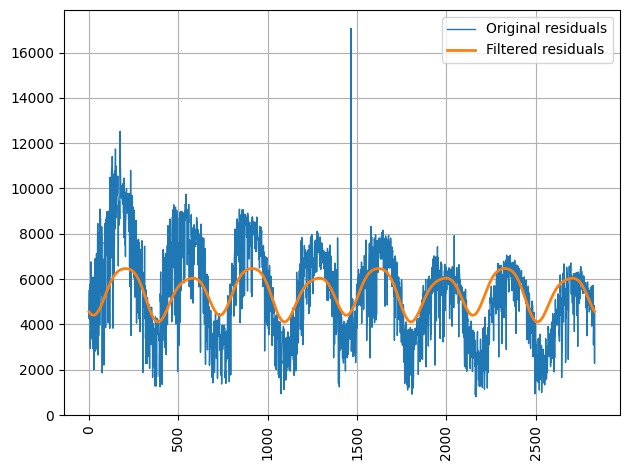

In [24]:
plt.plot(time_index, series, linewidth=1, label='Original residuals')
plt.plot(time_index, filtered_sig+series.mean(), linewidth=2, label='Filtered residuals')
plt.legend(loc='upper right')
plt.grid()

plt.xticks(rotation=90)
plt.tight_layout()

# TODO: fix these coefficients to match current data

In [25]:
import cmath
A1, f1, = 0.75, 0.002791
phase = cmath.phase(194.102798-167.651352j)
y1 = A1 * np.sin(2*np.pi * f1 * time_index - phase)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot: xlabel='timestamp'>

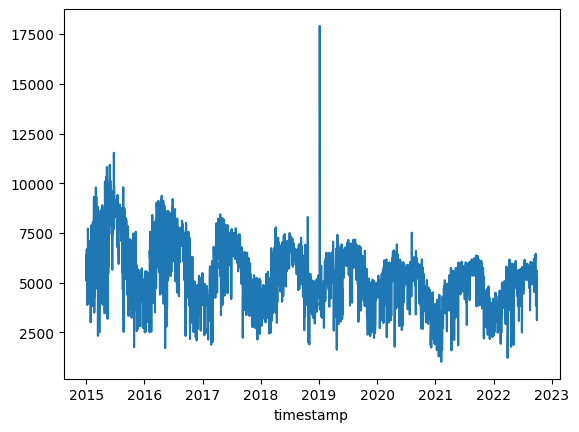

In [26]:
new_data = series - filtered_sig
sns.lineplot(x=sample_site.index, y=new_data)

***Note***: some preprocessing still needs to be done to remove outliers before this point in the notebook

Then, we can generate a function f(time of day, day of year) = expected PV output

We can select a sample site for this proof of concept. The following site was chosen because it had the most data points out of all sites.

In [27]:
sample_site = pv_df[pv_df['system_id'] == 32779].reset_index()

### Seasonality for yearly data

We first aggregate data from across years by month

In [28]:
sample_site['timestamp'] = sample_site['timestamp'].apply(lambda t: t[5:])
sample_site = sample_site.groupby('timestamp').mean()

In [29]:
pv_output = sample_site['instantaneous_power_W']

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

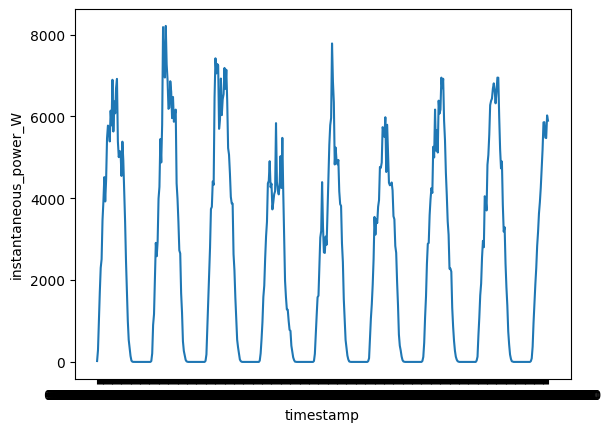

In [30]:
sns.lineplot(pv_output[:500])

Then we take the maximum datapoints for each day.

In [31]:
pv_output = pv_output.reset_index()
pv_output['timestamp'] = pv_output['timestamp'].apply(lambda t: t[:5])
pv_output.head()

,timestamp,instantaneous_power_W
0,01-01,21.666667
1,01-01,288.833333
2,01-01,1017.714286
3,01-01,1700.047619
4,01-01,2298.285714


In [32]:
daily_max = pv_output.groupby('timestamp')['instantaneous_power_W'].apply(lambda n: n.nlargest(5).mean())

Seems like the daily maximum energy output varies notably throughout the year.

<AxesSubplot: >

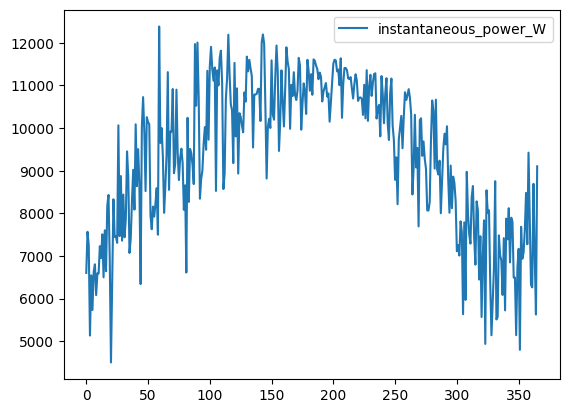

In [33]:
sns.lineplot(daily_max.reset_index())

I'll concatenate the data with itself to generate a nice multi-year trend

In [34]:
daily_max = pd.concat([daily_max for i in range(3)])
daily_max = daily_max.reset_index()

In [35]:
daily_max.head()

,timestamp,instantaneous_power_W
0,01-01,6603.714286
1,01-02,7567.504762
2,01-03,7255.844444
3,01-04,5135.276190
4,01-05,6546.400000


Let's use curve fitting to model yearly seasonality

In [36]:
from numpy import polyfit

series = daily_max['instantaneous_power_W'].values
X = [i%365 for i in range(0, len(series))]
y = series
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [ 2.13258970e-06 -1.42118695e-03  1.46549615e-01  3.15371883e+01
  6.80824701e+03]


<AxesSubplot: >

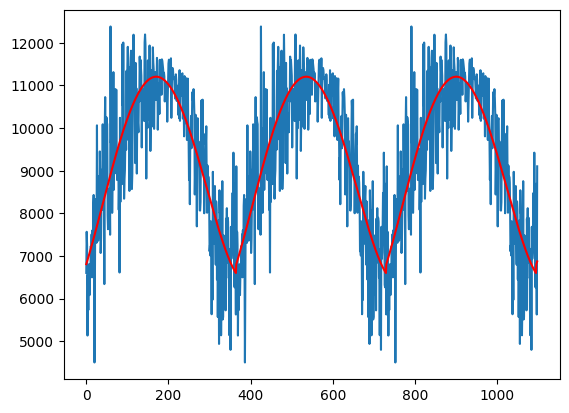

In [37]:
def generate_curve(X, coef, degree):
    curve = list()
    for i in range(len(X)):
         value = coef[-1]
         for d in range(degree):
              value += X[i]**(degree-d) * coef[d]
         curve.append(value)
    return curve

curve = generate_curve(X, coef, degree)
sns.lineplot(series)
sns.lineplot(curve, color='red')

<AxesSubplot: >

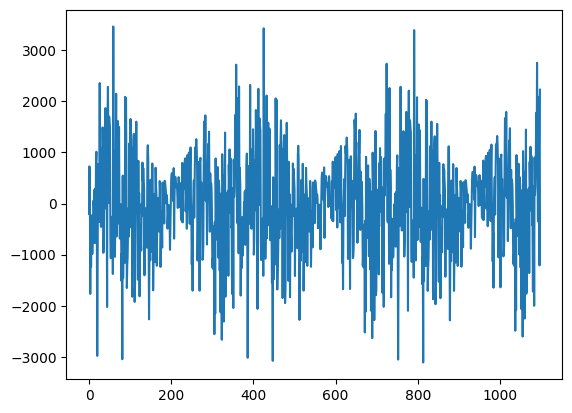

In [38]:
# create seasonally adjusted
def yearly_adjust(series, curve):
    values = series
    diff = list()
    for i in range(len(values)):
        value = values[i] - curve[i]
        diff.append(value)

    return diff

diff = yearly_adjust(series, curve)
sns.lineplot(x=daily_max.index, y=diff)

# Temporal encoding & seasonality representation for intraday data

We've already aggregated our sample PV site across years by day and time

In [87]:
pv_output = sample_site['instantaneous_power_W']

We can seasonally adjust this data with our yearly seasonality

In [88]:
from datetime import datetime

day_of_year = pd.Series(pv_output.index).apply(lambda d: d[:5])
day_of_year.head(500)
# datetime.now().timetuple().tm_yday
# pv_output.head().index

#python hates leap days
def myfun(d):
    if d == '02-29':
        return datetime.strptime('02-28', '%m-%d')
    else:
        return datetime.strptime(d, '%m-%d')


y1 = day_of_year.apply(lambda d: myfun(d))
y2 = y1.apply(lambda d: d.timetuple().tm_yday)

In [89]:
def curve_eqn(coef, degree, x):
    value = 0
    for d in range(degree):
        #print(value, degree, d, coef[d])
        value += x**(degree-d) * coef[d]
    return value

def yearly_adjust(coef, degree, series):
    diff = list()
    for i in range(len(series)):
        diff.append(series[i] / curve_eqn(coef, degree, series[i]))

    return diff

#pv_output = pd.Series(yearly_adjust(coef, degree, pv_output.values))
curve = pd.Series(generate_curve(y2, coef, degree), index=pv_output.index)
pv_output2 = pv_output / curve
#pv_output = pv_output.apply(lambda x: x - curve_eqn(coef, degree, x))

<AxesSubplot: xlabel='timestamp', ylabel='instantaneous_power_W'>

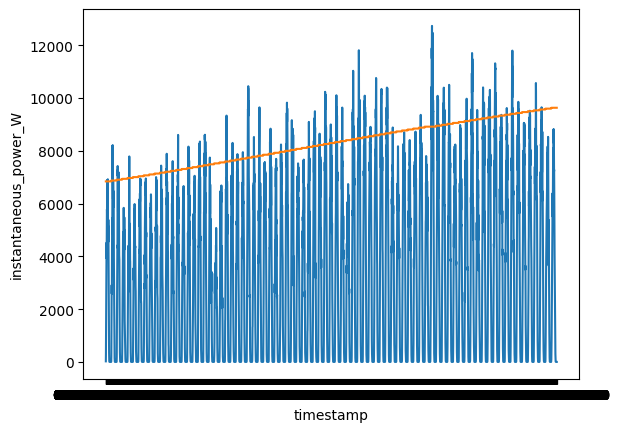

In [72]:
#sns.lineplot(sample_site['instantaneous_power_W'].head(500), color='green')
#sns.lineplot(sample_site['instantaneous_power_W'].head(500).apply(lambda x: curve_eqn(coef, degree, x)))
sns.lineplot(pv_output.head(5000))
sns.lineplot(curve.head(5000))

Here we have our data adjusted for yearly seasonality. The idea is that if we plot the daily maximum over the course of the year, it should now be centered at 1.0.

<AxesSubplot: xlabel='timestamp', ylabel='0'>

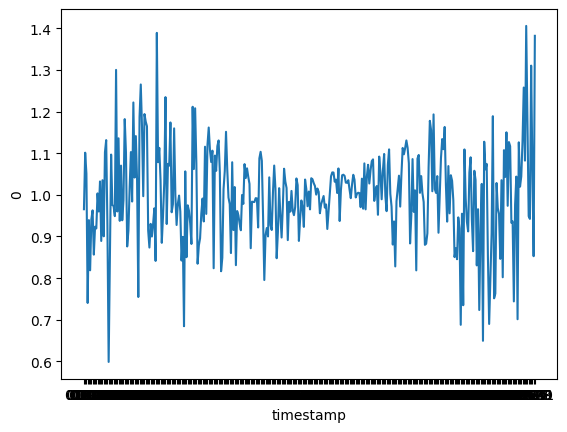

In [73]:
pv_output3 = pv_output2.reset_index()
pv_output3['timestamp'] = pv_output3['timestamp'].apply(lambda t: t[:5])
daily_max2 = pv_output3.groupby('timestamp')[0].apply(lambda n: n.nlargest(5).mean())
sns.lineplot(daily_max2)

Let's model daily seasonality. Let's try SARIMA this time.
Use SARIMA, Fourier features, or polynomial fits to model daily seasonality

In [90]:

pv_output2.index = pd.Series(pv_output2.index).apply(lambda x: x[6:])
pv_output2.head()
#pv_output = pd.DataFrame(pv_output2, index = pv_output2.index)

timestamp
07:15:00    0.003168
07:30:00    0.042228
07:45:00    0.148790
08:00:00    0.248548
08:15:00    0.336010
dtype: float64

In [91]:
pv_output2.groupby('timestamp').mean()
pv_output2.head()


timestamp
07:15:00    0.003168
07:30:00    0.042228
07:45:00    0.148790
08:00:00    0.248548
08:15:00    0.336010
dtype: float64

In [ ]:
sns.lineplot(pv_output.head(500))

Error in callback <function _draw_all_if_interactive at 0x13010bf70> (for post_execute):



KeyboardInterrupt



In [61]:


# python hates leap years so I'll just make the year 2020 so it doesn't complain
# pv_output2.index = pd.Series(pv_output2.index).apply(lambda s: '2020-'+ s)
# pv_output2.index = pd.to_datetime(pv_output2.index, format='%Y-%m-%d %H:%M:%S')
# pv_output2.head()

timestamp
2020-01-01 07:15:00    0.003168
2020-01-01 07:30:00    0.042228
2020-01-01 07:45:00    0.148790
2020-01-01 08:00:00    0.248548
2020-01-01 08:15:00    0.336010
dtype: float64

In [67]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# pv_output2.index.freq = '15T'
# result = seasonal_decompose(pv_output2.head(500), model='additive')
#
# fig = result.plot()


ValueError: Inferred frequency None from passed values does not conform to passed frequency 15T

SciPy has a curve fitting method that use non-linear least squares to fit a function, f, to data. Let's try it with a sine function.

In [ ]:
from scipy.optimize import curve_fit

def sine(x, a, b, c):
    return a*x**2 + b*x + c

coefs, _ = curve_fit(sine, np.arange(0,366*10), daily_max['instantaneous_power_W'], p0=[7000, 0.002732, 5000, 0], bounds=[(5000,0.0005, 5000, -60), (10000, 0.2, 8000, 60)])
print(coefs)

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(np.arange(0,366), daily_max['instantaneous_power_W'][:366], label='Data')
plt.plot(np.arange(0,366), sine(np.arange(0,366), coefs[0], coefs[1], coefs[2]),label='Fitted function')
plt.legend(loc='best')
plt.show()